## **House Prices Prediction:**  

**It includes the following approaches and techniques:**

* EDA with Pandas and Seaborn
* Find features with strong correlation to target
* Data Wrangling, convert categorical to numerical
* apply the basic Regression models of sklearn 
* use gridsearchCV to find the best parameters for each model
* compare the performance of the Regressors and choose best one


**Data description**  
This is a detailed description of the 79 features and their entries, quite important for this competition.  
You can download the txt file here: [**download**](https://www.kaggle.com/c/5407/download/data_description.txt)

# Part 0 : Imports, Settings, Functions

**Imports**

In [115]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
%matplotlib inline
sns.set()

**Settings and switches**

**Here one can choose settings for optimal performance and runtime.**  
**For example, nr_cv sets the number of cross validations used in GridsearchCV, and**  
**min_val_corr is the minimum value for the correlation coefficient to the target (only features with larger correlation will be used).** 

In [116]:
# setting the number of cross validations used in the Model part 
nr_cv = 5

# switch for using log values for SalePrice and features     
use_logvals = 1    
# target used for correlation 
target = 'SalePrice_Log'
    
# only columns with correlation above this threshold value  
# are used for the ML Regressors in Part 3
min_val_corr = 0.4    
    
# switch for dropping columns that are similar to others already used and show a high correlation to these     
drop_similar = 1


**Some useful functions**

In [117]:
def get_best_score(grid):
    
    best_score = np.sqrt(-grid.best_score_)
    print(best_score)    
    print(grid.best_params_)
    print(grid.best_estimator_)
    
    return best_score

In [118]:
def print_cols_large_corr(df, nr_c, targ) :
    corr = df.corr()
    corr_abs = corr.abs()
    print (corr_abs.nlargest(nr_c, targ)[targ])

In [119]:
def plot_corr_matrix(df, nr_c, targ) :
    
    corr = df.corr()
    corr_abs = corr.abs()
    cols = corr_abs.nlargest(nr_c, targ)[targ].index
    cm = np.corrcoef(df[cols].values.T)

    plt.figure(figsize=(nr_c/1.5, nr_c/1.5))
    sns.set(font_scale=1.25)
    sns.heatmap(cm, linewidths=1.5, annot=True, square=True, 
                fmt='.2f', annot_kws={'size': 10}, 
                yticklabels=cols.values, xticklabels=cols.values
               )
    plt.show()

**Load data**

In [120]:
df_train = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")

# Part 1: Exploratory Data Analysis

## 1.1 Overview of features and relation to target

Let's get a first overview of the train and test dataset  
How many rows and columns are there?  
What are the names of the features (columns)?  
Which features are numerical, which are categorical?  
How many values are missing?  
The **shape** and **info** methods answer these questions  
**head** displays some rows of the dataset  
**describe** gives a summary of the statistics (only for numerical columns)

### shape, info, head and describe

In [121]:
print(df_train.shape)
print("*"*50)
print(df_test.shape)

(1460, 81)
**************************************************
(1459, 80)


In [122]:
print(df_train.info())
print("*"*50)
print(df_test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

df train has 81 columns (79 features + id and target SalePrice) and 1460 entries (number of rows or house sales)  
df test has 80 columns (79 features + id) and 1459 entries  
There is lots of info that is probably related to the SalePrice like the area, the neighborhood, the condition and quality.   
Maybe other features are not so important for predicting the target, also there might be a strong correlation for some of the features (like GarageCars and GarageArea).
For some columns many values are missing: only 7 values for Pool QC in df train and 3 in df test

In [123]:
df_train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [124]:
df_train.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [125]:
df_test.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [126]:
df_test.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
count,1459.000000,1459.000000,1232.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1444.000000,1458.000000,...,1458.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000
mean,2190.000000,57.378341,68.580357,9819.161069,6.078821,5.553804,1971.357779,1983.662783,100.709141,439.203704,...,472.768861,93.174777,48.313914,24.243317,1.794380,17.064428,1.744345,58.167923,6.104181,2007.769705
std,421.321334,42.746880,22.376841,4955.517327,1.436812,1.113740,30.390071,21.130467,177.625900,455.268042,...,217.048611,127.744882,68.883364,67.227765,20.207842,56.609763,30.491646,630.806978,2.722432,1.301740
min,1461.000000,20.000000,21.000000,1470.000000,1.000000,1.000000,1879.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000
25%,1825.500000,20.000000,58.000000,7391.000000,5.000000,5.000000,1953.000000,1963.000000,0.000000,0.000000,...,318.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,2007.000000
50%,2190.000000,50.000000,67.000000,9399.000000,6.000000,5.000000,1973.000000,1992.000000,0.000000,350.500000,...,480.000000,0.000000,28.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000
75%,2554.500000,70.000000,80.000000,11517.500000,7.000000,6.000000,2001.000000,2004.000000,164.000000,753.500000,...,576.000000,168.000000,72.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000
max,2919.000000,190.000000,200.000000,56600.000000,10.000000,9.000000,2010.000000,2010.000000,1290.000000,4010.000000,...,1488.000000,1424.000000,742.000000,1012.000000,360.000000,576.000000,800.000000,17000.000000,12.000000,2010.000000


### The target variable : Distribution of SalePrice

C:\Users\harshavardhan\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Skewness: 1.882876
Kurtosis: 6.536282


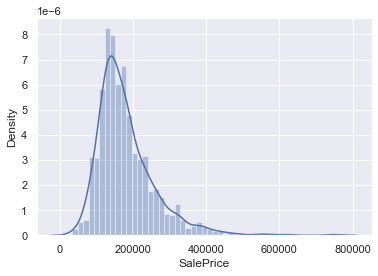

In [127]:
sns.distplot(df_train['SalePrice']);
#skewness and kurtosis
print("Skewness: %f" % df_train['SalePrice'].skew())
print("Kurtosis: %f" % df_train['SalePrice'].kurt())

As we see, the target variable SalePrice is not normally distributed.  
This can reduce the performance of the ML regression models because some assume normal distribution,   
see [sklearn info on preprocessing](http://scikit-learn.org/stable/modules/preprocessing.html)  
Therfore we make a log transformation, the resulting distribution looks much better.  

Skewness: 0.121335
Kurtosis: 0.809532


C:\Users\harshavardhan\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


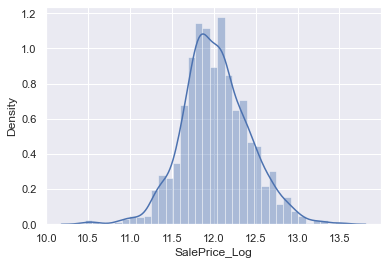

In [128]:
df_train['SalePrice_Log'] = np.log(df_train['SalePrice'])

sns.distplot(df_train['SalePrice_Log']);
# skewness and kurtosis
print("Skewness: %f" % df_train['SalePrice_Log'].skew())
print("Kurtosis: %f" % df_train['SalePrice_Log'].kurt())
# dropping old column
df_train.drop('SalePrice', axis= 1, inplace=True)

### Numerical and Categorical features

In [129]:
numerical_feats = df_train.dtypes[df_train.dtypes != "object"].index
print("Number of Numerical features: ", len(numerical_feats))

categorical_feats = df_train.dtypes[df_train.dtypes == "object"].index
print("Number of Categorical features: ", len(categorical_feats))

Number of Numerical features:  38
Number of Categorical features:  43


In [130]:
print(df_train[numerical_feats].columns)
print("*"*100)
print(df_train[categorical_feats].columns)

Index(['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd',
       'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF',
       'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea',
       'MiscVal', 'MoSold', 'YrSold', 'SalePrice_Log'],
      dtype='object')
****************************************************************************************************
Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Founda

In [131]:
df_train[numerical_feats].head()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice_Log
0,1,60,65.0,8450,7,5,2003,2003,196.0,706,...,0,61,0,0,0,0,0,2,2008,12.247694
1,2,20,80.0,9600,6,8,1976,1976,0.0,978,...,298,0,0,0,0,0,0,5,2007,12.109011
2,3,60,68.0,11250,7,5,2001,2002,162.0,486,...,0,42,0,0,0,0,0,9,2008,12.317167
3,4,70,60.0,9550,7,5,1915,1970,0.0,216,...,0,35,272,0,0,0,0,2,2006,11.849398
4,5,60,84.0,14260,8,5,2000,2000,350.0,655,...,192,84,0,0,0,0,0,12,2008,12.429216


In [132]:
df_train[categorical_feats].head()

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,...,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
0,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
1,RL,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
2,RL,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
3,RL,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,...,Detchd,Unf,TA,TA,Y,NaN,NaN,NaN,WD,Abnorml
4,RL,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal


### List of features with missing values

In [133]:
total = df_train.isnull().sum().sort_values(ascending=False)
percent = (df_train.isnull().sum()/df_train.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
PoolQC,1453,0.995205
MiscFeature,1406,0.963014
Alley,1369,0.937671
Fence,1179,0.807534
FireplaceQu,690,0.472603
LotFrontage,259,0.177397
GarageYrBlt,81,0.055479
GarageCond,81,0.055479
GarageType,81,0.055479
GarageFinish,81,0.055479


**Filling missing values**  
For a few columns there is lots of NaN entries.  
However, reading the data description we find this is not missing data:  
For PoolQC, NaN is not missing data but means no pool, likewise for Fence, FireplaceQu etc.  

In [134]:
# columns where NaN values have meaning e.g. no pool etc.
cols_fillna = ['PoolQC','MiscFeature','Alley','Fence','MasVnrType','FireplaceQu',
               'GarageQual','GarageCond','GarageFinish','GarageType', 'Electrical',
               'KitchenQual', 'SaleType', 'Functional', 'Exterior2nd', 'Exterior1st',
               'BsmtExposure','BsmtCond','BsmtQual','BsmtFinType1','BsmtFinType2',
               'MSZoning', 'Utilities']

# replace 'NaN' with 'None' in these columns
for col in cols_fillna:
    df_train[col].fillna('None',inplace=True)
    df_test[col].fillna('None',inplace=True)

In [135]:
total = df_train.isnull().sum().sort_values(ascending=False)
percent = (df_train.isnull().sum()/df_train.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(5)

,Total,Percent
LotFrontage,259,0.177397
GarageYrBlt,81,0.055479
MasVnrArea,8,0.005479
Id,0,0.000000
KitchenAbvGr,0,0.000000


In [136]:
# fillna with mean for the remaining columns: LotFrontage, GarageYrBlt, MasVnrArea
df_train.fillna(df_train.mean(), inplace=True)
df_test.fillna(df_test.mean(), inplace=True)

C:\Users\harshavardhan\AppData\Local\Temp\ipykernel_33780\1810484902.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df_train.fillna(df_train.mean(), inplace=True)
C:\Users\harshavardhan\AppData\Local\Temp\ipykernel_33780\1810484902.py:3: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df_test.fillna(df_test.mean(), inplace=True)


In [137]:
total = df_train.isnull().sum().sort_values(ascending=False)
percent = (df_train.isnull().sum()/df_train.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(10)

,Total,Percent
Id,0,0.0
CentralAir,0,0.0
GarageYrBlt,0,0.0
GarageType,0,0.0
FireplaceQu,0,0.0
Fireplaces,0,0.0
Functional,0,0.0
TotRmsAbvGrd,0,0.0
KitchenQual,0,0.0
KitchenAbvGr,0,0.0


**Missing values in train data ?**

In [138]:
df_train.isnull().sum().sum()

0

**Missing values in test data ?**

In [139]:
df_test.isnull().sum().sum()

0

### log transform
Like the target variable, also some of the feature values are not normally distributed and it is therefore better to use log values in df_train and df_test. Checking for skewness and kurtosis:

In [140]:
for col in numerical_feats:
    print('{:15}'.format(col), 
          'Skewness: {:05.2f}'.format(df_train[col].skew()) , 
          '   ' ,
          'Kurtosis: {:06.2f}'.format(df_train[col].kurt())  
         )

Id              Skewness: 00.00     Kurtosis: -01.20
MSSubClass      Skewness: 01.41     Kurtosis: 001.58
LotFrontage     Skewness: 02.38     Kurtosis: 021.85
LotArea         Skewness: 12.21     Kurtosis: 203.24
OverallQual     Skewness: 00.22     Kurtosis: 000.10
OverallCond     Skewness: 00.69     Kurtosis: 001.11
YearBuilt       Skewness: -0.61     Kurtosis: -00.44
YearRemodAdd    Skewness: -0.50     Kurtosis: -01.27
MasVnrArea      Skewness: 02.68     Kurtosis: 010.15
BsmtFinSF1      Skewness: 01.69     Kurtosis: 011.12
BsmtFinSF2      Skewness: 04.26     Kurtosis: 020.11
BsmtUnfSF       Skewness: 00.92     Kurtosis: 000.47
TotalBsmtSF     Skewness: 01.52     Kurtosis: 013.25
1stFlrSF        Skewness: 01.38     Kurtosis: 005.75
2ndFlrSF        Skewness: 00.81     Kurtosis: -00.55
LowQualFinSF    Skewness: 09.01     Kurtosis: 083.23
GrLivArea       Skewness: 01.37     Kurtosis: 004.90
BsmtFullBath    Skewness: 00.60     Kurtosis: -00.84
BsmtHalfBath    Skewness: 04.10     Kurtosis: 

Skewness: 1.366560
Kurtosis: 4.895121


C:\Users\harshavardhan\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


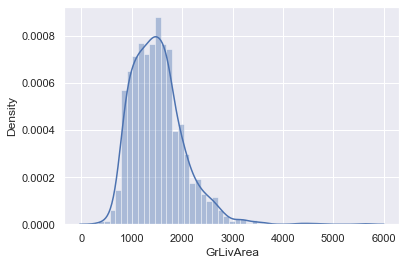

In [141]:
sns.distplot(df_train['GrLivArea']);
#skewness and kurtosis
print("Skewness: %f" % df_train['GrLivArea'].skew())
print("Kurtosis: %f" % df_train['GrLivArea'].kurt())

Skewness: 12.207688
Kurtosis: 203.243271


C:\Users\harshavardhan\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


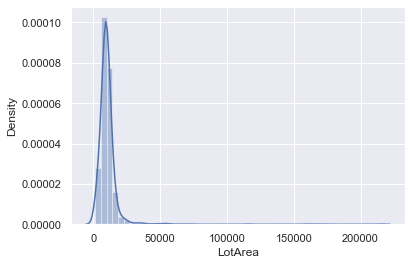

In [142]:
sns.distplot(df_train['LotArea']);
#skewness and kurtosis
print("Skewness: %f" % df_train['LotArea'].skew())
print("Kurtosis: %f" % df_train['LotArea'].kurt())

In [143]:
for df in [df_train, df_test]:
    df['GrLivArea_Log'] = np.log(df['GrLivArea'])
    df.drop('GrLivArea', inplace= True, axis = 1)
    df['LotArea_Log'] = np.log(df['LotArea'])
    df.drop('LotArea', inplace= True, axis = 1)
    
    
    
numerical_feats = df_train.dtypes[df_train.dtypes != "object"].index
   

Skewness: -0.006995
Kurtosis: 0.282603


C:\Users\harshavardhan\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


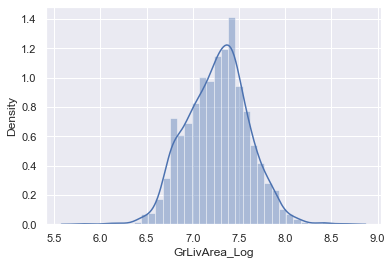

In [144]:
sns.distplot(df_train['GrLivArea_Log']);
#skewness and kurtosis
print("Skewness: %f" % df_train['GrLivArea_Log'].skew())
print("Kurtosis: %f" % df_train['GrLivArea_Log'].kurt())

C:\Users\harshavardhan\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Skewness: -0.137994
Kurtosis: 4.713358


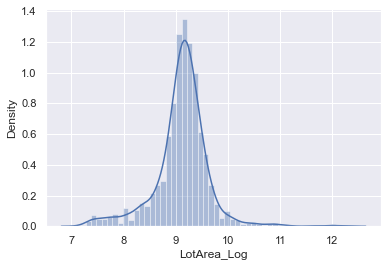

In [145]:
sns.distplot(df_train['LotArea_Log']);
#skewness and kurtosis
print("Skewness: %f" % df_train['LotArea_Log'].skew())
print("Kurtosis: %f" % df_train['LotArea_Log'].kurt())

## 1.2 Relation of features to target (SalePrice_log)

### Plots of relation to target for all numerical features

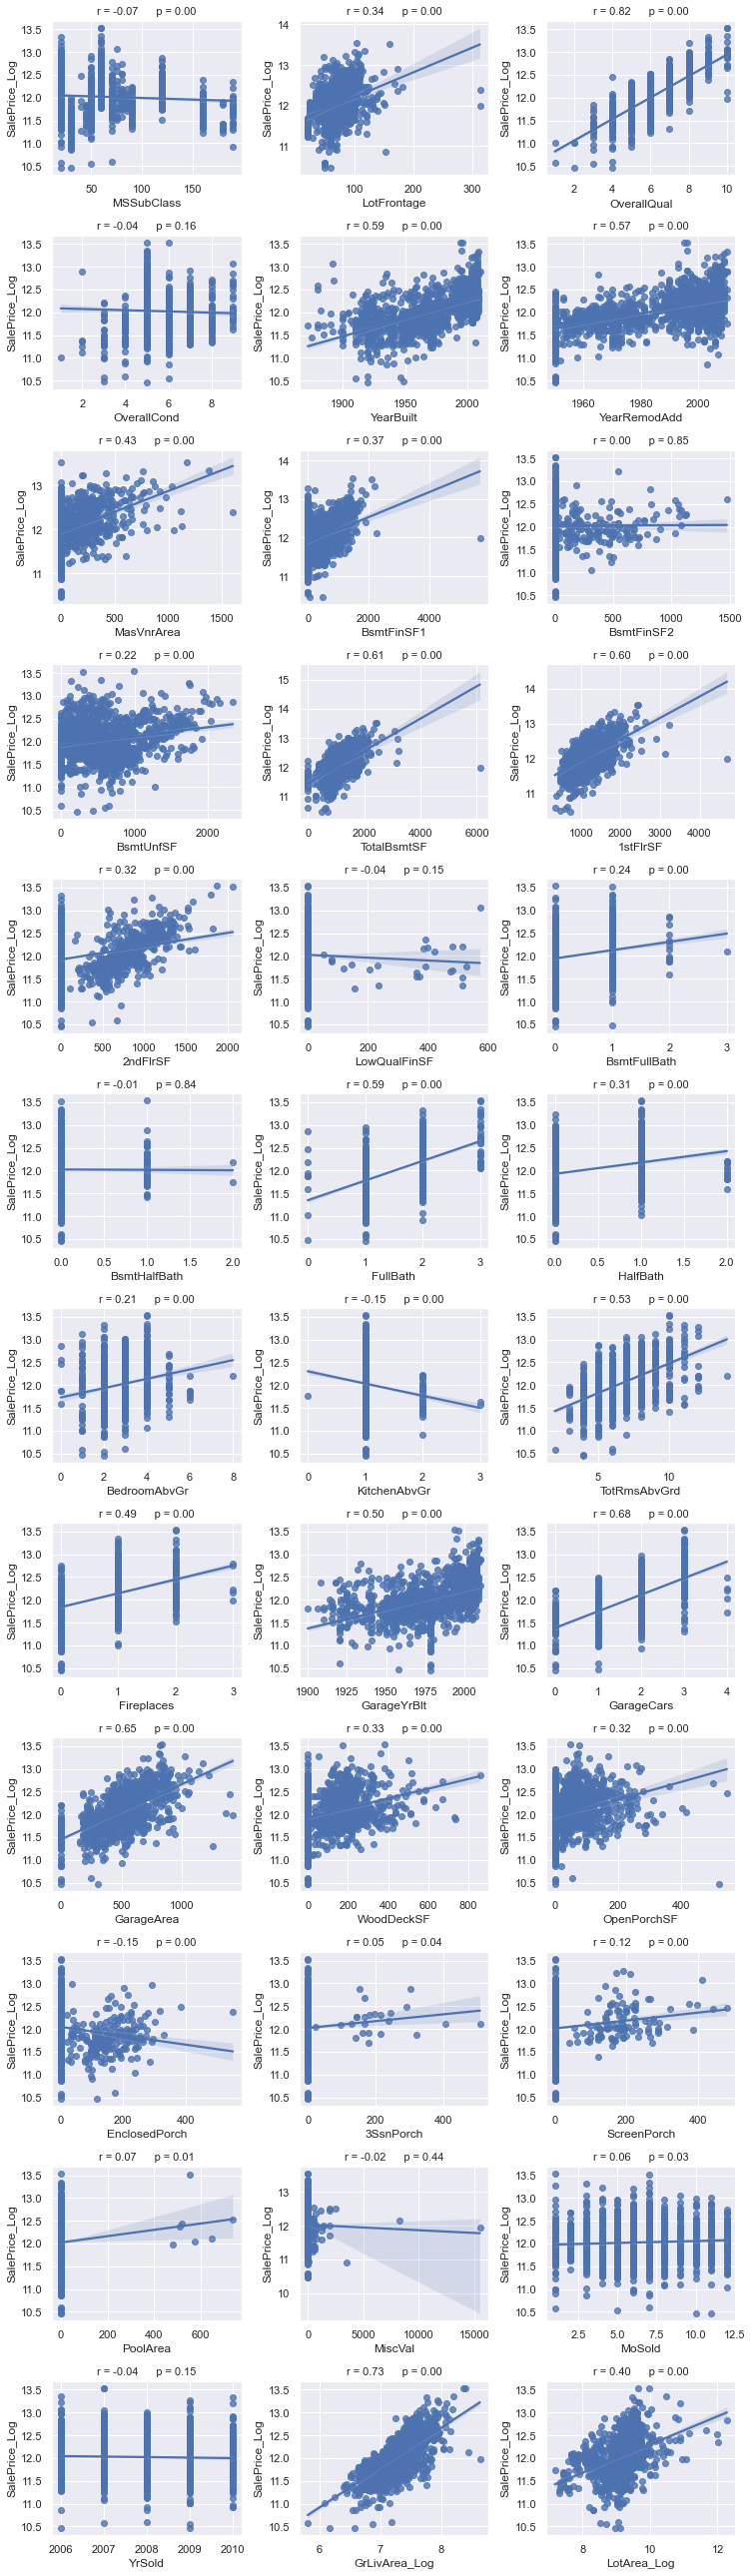

In [146]:
nr_rows = 12
nr_cols = 3

fig, axs = plt.subplots(nr_rows, nr_cols, figsize=(nr_cols*3.5,nr_rows*3))

li_num_feats = list(numerical_feats)
li_not_plot = ['Id', 'SalePrice', 'SalePrice_Log']
li_plot_num_feats = [c for c in list(numerical_feats) if c not in li_not_plot]


for r in range(0,nr_rows):
    for c in range(0,nr_cols):  
        i = r*nr_cols+c
        if i < len(li_plot_num_feats):
            sns.regplot(x=df_train[li_plot_num_feats[i]], y=df_train[target], ax = axs[r][c])
            stp = stats.pearsonr(df_train[li_plot_num_feats[i]], df_train[target])
            #axs[r][c].text(0.4,0.9,"title",fontsize=7)
            str_title = "r = " + "{0:.2f}".format(stp[0]) + "      " "p = " + "{0:.2f}".format(stp[1])
            axs[r][c].set_title(str_title,fontsize=11)
            
plt.tight_layout()    
plt.show()   

**Conclusion from EDA on numerical columns:**

We see that for some features like 'OverallQual' there is a strong linear correlation (0.82) to the target.  
For other features like 'MSSubClass' the correlation is very weak.  
For this  I decided to use only those features for prediction that have a correlation larger than a threshold value to SalePrice.  
This threshold value can be choosen in the global settings : min_val_corr  

With the default threshold for min_val_corr = 0.4, these features are dropped in Part 2, Data Wrangling:  
'Id', 'MSSubClass', 'LotArea', 'OverallCond', 'BsmtFinSF2', 'BsmtUnfSF',  'LowQualFinSF',  'BsmtFullBath', 'BsmtHalfBath', 'HalfBath',   
'BedroomAbvGr', 'KitchenAbvGr', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold'

We also see that the entries for some of the numerical columns are in fact categorical values.  
For example, the numbers for 'OverallQual' and 'MSSubClass' represent a certain group for that feature ( see data description txt)

**Outliers**

In [147]:
df_train = df_train.drop(
    df_train[(df_train['OverallQual']==10) & (df_train['SalePrice_Log']<12.3)].index)

In [148]:
df_train = df_train.drop(
    df_train[(df_train['GrLivArea_Log']>8.3) & (df_train['SalePrice_Log']<12.5)].index)

In [149]:
df_train.head()

,Id,MSSubClass,MSZoning,LotFrontage,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice_Log,GrLivArea_Log,LotArea_Log
0,1,60,RL,65.0,Pave,None,Reg,Lvl,AllPub,Inside,...,None,None,0,2,2008,WD,Normal,12.247694,7.444249,9.041922
1,2,20,RL,80.0,Pave,None,Reg,Lvl,AllPub,FR2,...,None,None,0,5,2007,WD,Normal,12.109011,7.140453,9.169518
2,3,60,RL,68.0,Pave,None,IR1,Lvl,AllPub,Inside,...,None,None,0,9,2008,WD,Normal,12.317167,7.487734,9.328123
3,4,70,RL,60.0,Pave,None,IR1,Lvl,AllPub,Corner,...,None,None,0,2,2006,WD,Abnorml,11.849398,7.448334,9.164296
4,5,60,RL,84.0,Pave,None,IR1,Lvl,AllPub,FR2,...,None,None,0,12,2008,WD,Normal,12.429216,7.695303,9.565214


**Find columns with strong correlation to target**  
Only those with r > min_val_corr are used in the ML Regressors in Part 3  
The value for min_val_corr can be chosen in global settings

In [150]:
corr = df_train.corr()
corr_abs = corr.abs()

nr_num_cols = len(numerical_feats)
ser_corr = corr_abs.nlargest(nr_num_cols, target)[target]

cols_abv_corr_limit = list(ser_corr[ser_corr.values > min_val_corr].index)
cols_bel_corr_limit = list(ser_corr[ser_corr.values <= min_val_corr].index)

### List of numerical features and their correlation coefficient to target

In [151]:
print(ser_corr)
print("*"*30)
print("List of numerical features with r above min_val_corr :")
print(cols_abv_corr_limit)
print("*"*30)
print("List of numerical features with r below min_val_corr :")
print(cols_bel_corr_limit)


SalePrice_Log    1.000000
OverallQual      0.821404
GrLivArea_Log    0.737427
GarageCars       0.681033
GarageArea       0.656128
TotalBsmtSF      0.647563
1stFlrSF         0.620500
FullBath         0.595899
YearBuilt        0.587043
YearRemodAdd     0.565992
TotRmsAbvGrd     0.537702
GarageYrBlt      0.500842
Fireplaces       0.491998
MasVnrArea       0.433353
LotArea_Log      0.402814
BsmtFinSF1       0.392283
LotFrontage      0.352432
WoodDeckSF       0.334250
OpenPorchSF      0.325215
2ndFlrSF         0.319953
HalfBath         0.314186
BsmtFullBath     0.237099
BsmtUnfSF        0.221892
BedroomAbvGr     0.209036
EnclosedPorch    0.149029
KitchenAbvGr     0.147534
ScreenPorch      0.121245
PoolArea         0.074338
MSSubClass       0.073969
MoSold           0.057064
3SsnPorch        0.054914
LowQualFinSF     0.037951
YrSold           0.037151
OverallCond      0.036821
MiscVal          0.020012
Id               0.017774
BsmtHalfBath     0.005124
BsmtFinSF2       0.004863
Name: SalePr

### List of categorical features and their unique values

In [152]:
for catg in list(categorical_feats) :
    print(df_train[catg].value_counts())
    print('#'*50)

RL         1149
RM          218
FV           65
RH           16
C (all)      10
Name: MSZoning, dtype: int64
##################################################
Pave    1452
Grvl       6
Name: Street, dtype: int64
##################################################
None    1367
Grvl      50
Pave      41
Name: Alley, dtype: int64
##################################################
Reg    925
IR1    483
IR2     41
IR3      9
Name: LotShape, dtype: int64
##################################################
Lvl    1311
Bnk      61
HLS      50
Low      36
Name: LandContour, dtype: int64
##################################################
AllPub    1457
NoSeWa       1
Name: Utilities, dtype: int64
##################################################
Inside     1051
Corner      262
CulDSac      94
FR2          47
FR3           4
Name: LotConfig, dtype: int64
##################################################
Gtl    1380
Mod      65
Sev      13
Name: LandSlope, dtype: int64
###########################

### Relation to SalePrice for all categorical features

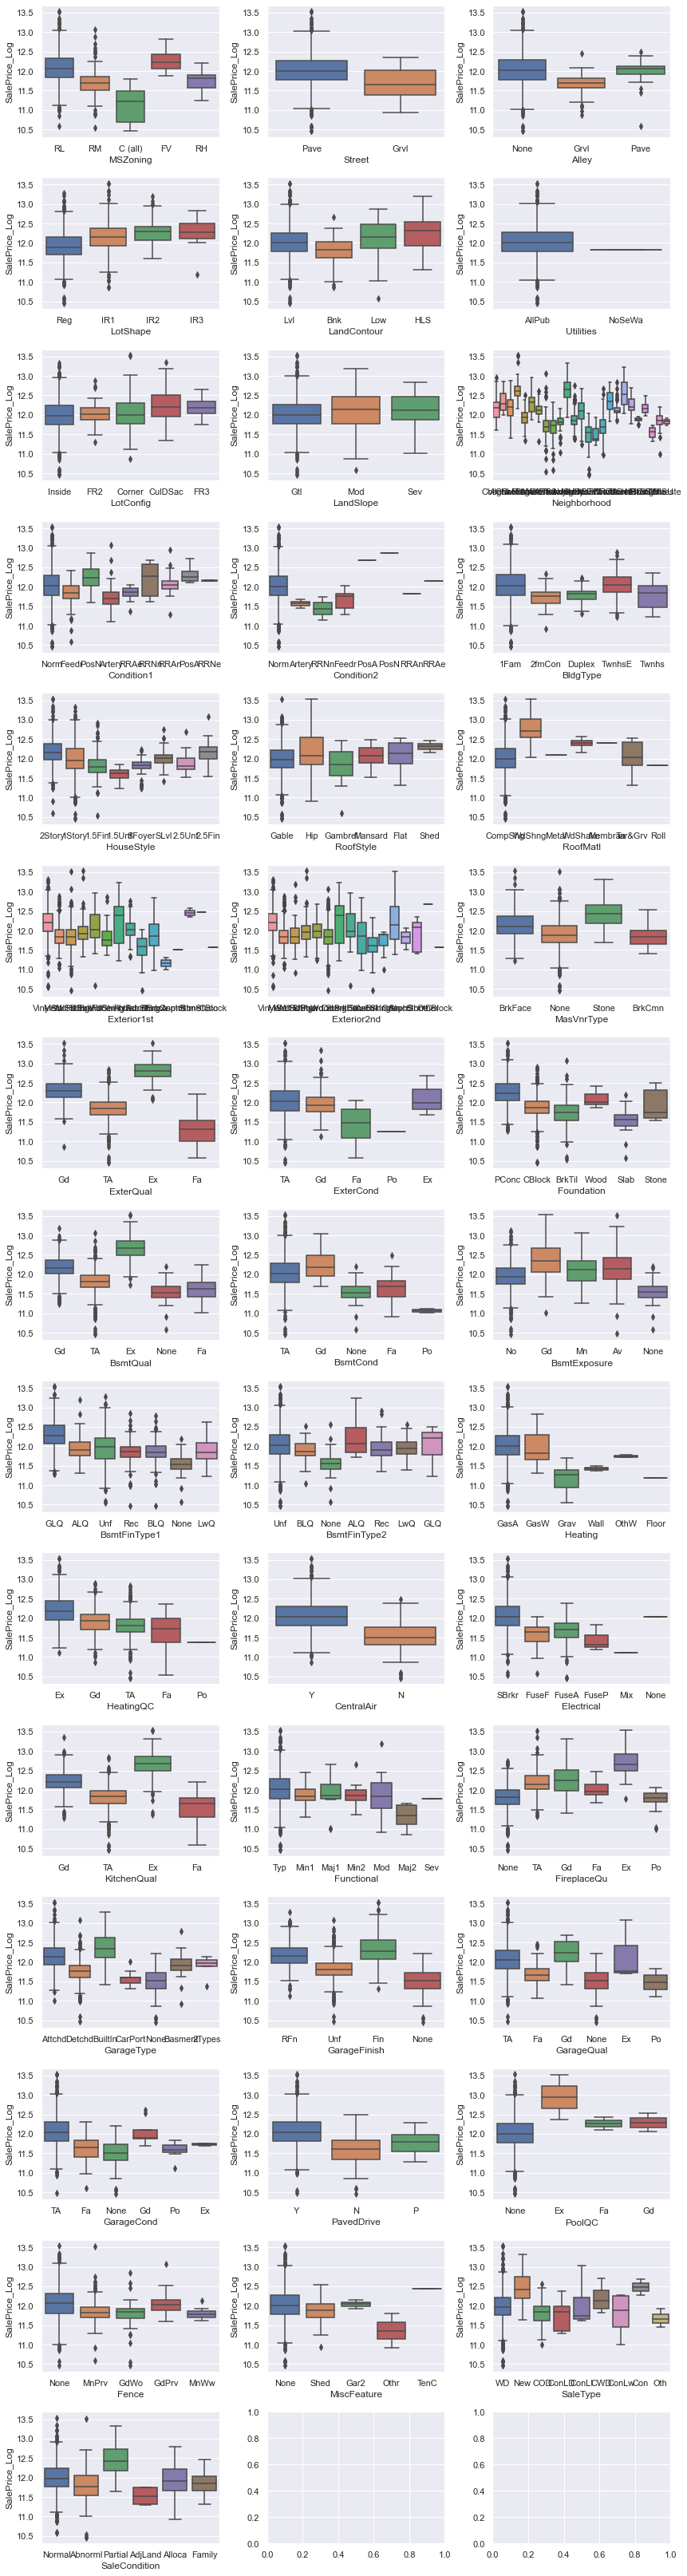

In [153]:
li_cat_feats = list(categorical_feats)
nr_rows = 15
nr_cols = 3

fig, axs = plt.subplots(nr_rows, nr_cols, figsize=(nr_cols*4,nr_rows*3))

for r in range(0,nr_rows):
    for c in range(0,nr_cols):  
        i = r*nr_cols+c
        if i < len(li_cat_feats):
            sns.boxplot(x=li_cat_feats[i], y=target, data=df_train, ax = axs[r][c])
    
plt.tight_layout()    
plt.show()   

**Conclusion from EDA on categorical columns:**

For many of the categorical there is no strong relation to the target.  
However, for some fetaures it is easy to find a strong relation.  
From the figures above these are : 'MSZoning', 'Neighborhood', 'Condition2', 'MasVnrType', 'ExterQual', 'BsmtQual','CentralAir', 'Electrical', 'KitchenQual', 'SaleType'
Also for the categorical features, I use only those that show a strong relation to SalePrice. 
So the other columns are dropped when creating the ML dataframes in Part 2 :  
 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Condition1',  'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl',
'Exterior1st', 'Exterior2nd', 'ExterCond', 'Foundation', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 
'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleCondition' 
 

In [154]:
catg_strong_corr = [ 'MSZoning', 'Neighborhood', 'Condition2', 'MasVnrType', 'ExterQual', 
                     'BsmtQual','CentralAir', 'Electrical', 'KitchenQual', 'SaleType']

catg_weak_corr = ['Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 
                  'LandSlope', 'Condition1',  'BldgType', 'HouseStyle', 'RoofStyle', 
                  'RoofMatl', 'Exterior1st', 'Exterior2nd', 'ExterCond', 'Foundation', 
                  'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 
                  'HeatingQC', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 
                  'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 
                  'SaleCondition' ]
      

### Correlation matrix 1
**Features with largest correlation to SalePrice_Log**  
all numerical features with correlation coefficient above threshold 

In [155]:
nr_feats = len(cols_abv_corr_limit)

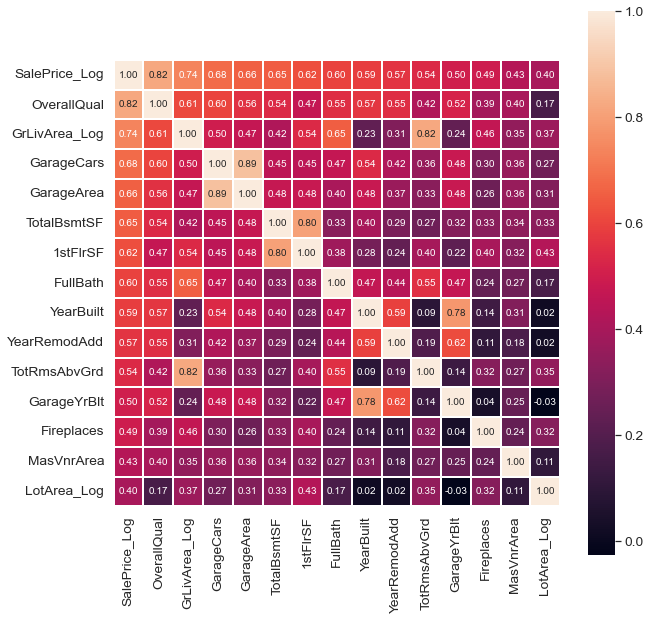

In [156]:
plot_corr_matrix(df_train, nr_feats, target)

**Of those features with the largest correlation to SalePrice, some also are correlated strongly to each other.**


**To avoid failures of the ML regression models due to multicollinearity, these are dropped in part 2.**


**This is optional and controlled by the switch drop_similar (global settings)**

# Part 2: Data wrangling

**Drop all columns with only small correlation to SalePrice**  
**Transform Categorical to numerical**  
**Handling columns with missing data**  
**Log values**  
**Drop all columns with strong correlation to similar features**  

Numerical columns : drop similar and low correlation

Categorical columns : Transform  to numerical

### Dropping all columns with weak correlation to SalePrice

In [157]:
id_test = df_test['Id']

to_drop_num  = cols_bel_corr_limit
to_drop_catg = catg_weak_corr

cols_to_drop = ['Id'] + to_drop_num + to_drop_catg 

for df in [df_train, df_test]:
    df.drop(cols_to_drop, inplace= True, axis = 1)


### Convert categorical columns to numerical  
For those categorcial features where the EDA with boxplots seem to show a strong dependence of the SalePrice on the category, we transform the columns to numerical.
To investigate the relation of the categories to SalePrice in more detail, we make violinplots for these features 
Also, we look at the mean of SalePrice as function of category.

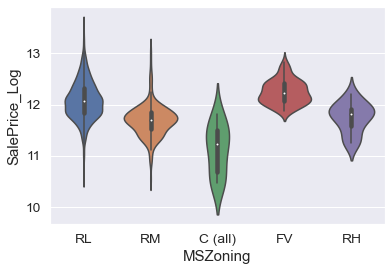

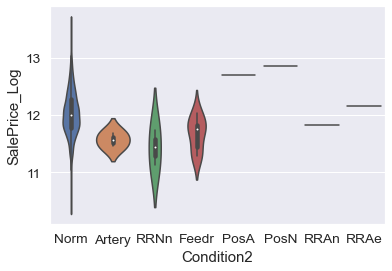

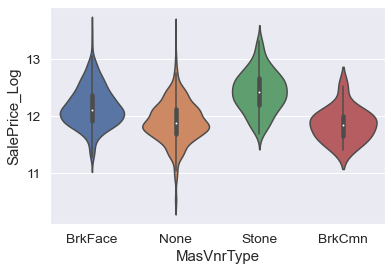

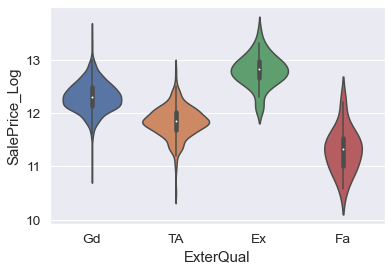

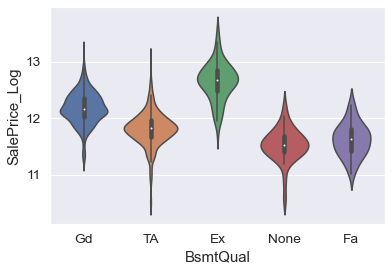

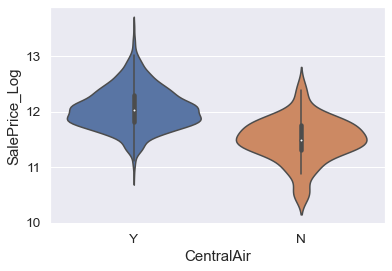

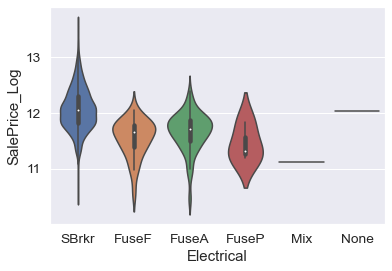

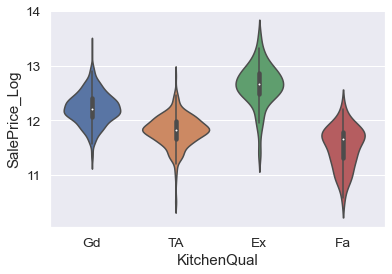

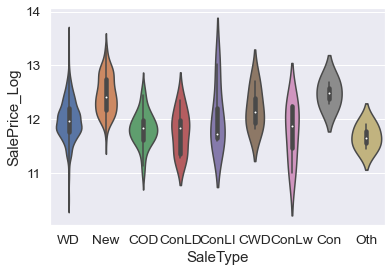

In [158]:
catg_list = catg_strong_corr.copy()
catg_list.remove('Neighborhood')

for catg in catg_list :
    #sns.catplot(x=catg, y=target, data=df_train, kind='boxen')
    sns.violinplot(x=catg, y=target, data=df_train)
    plt.show()
    #sns.boxenplot(x=catg, y=target, data=df_train)
    #bp = df_train.boxplot(column=[target], by=catg)

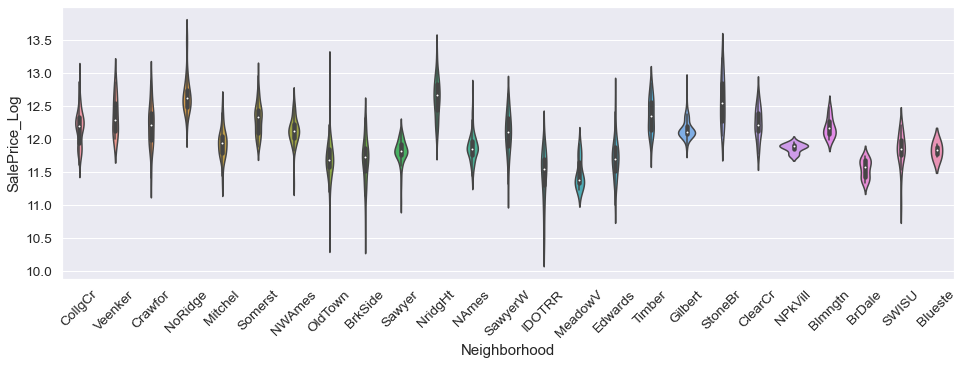

In [159]:
fig, ax = plt.subplots()
fig.set_size_inches(16, 5)
sns.violinplot(x='Neighborhood', y=target, data=df_train, ax=ax)
plt.xticks(rotation=45)
plt.show()

In [160]:
for catg in catg_list :
    g = df_train.groupby(catg)[target].mean()
    print(g)

MSZoning
C (all)    11.118259
FV         12.246616
RH         11.749840
RL         12.085939
RM         11.692893
Name: SalePrice_Log, dtype: float64
Condition2
Artery    11.570036
Feedr     11.670631
Norm      12.025925
PosA      12.691580
PosN      12.860999
RRAe      12.154779
RRAn      11.827043
RRNn      11.435329
Name: SalePrice_Log, dtype: float64
MasVnrType
BrkCmn     11.853239
BrkFace    12.163630
None       11.896884
Stone      12.431016
Name: SalePrice_Log, dtype: float64
ExterQual
Ex    12.792412
Fa    11.304541
Gd    12.311282
TA    11.837985
Name: SalePrice_Log, dtype: float64
BsmtQual
Ex      12.650235
Fa      11.617600
Gd      12.179882
None    11.529680
TA      11.810855
Name: SalePrice_Log, dtype: float64
CentralAir
N    11.491858
Y    12.061099
Name: SalePrice_Log, dtype: float64
Electrical
FuseA    11.660315
FuseF    11.539624
FuseP    11.446808
Mix      11.112448
None     12.028739
SBrkr    12.061474
Name: SalePrice_Log, dtype: float64
KitchenQual
Ex    12.645425
F

In [161]:
# 'MSZoning'
msz_catg2 = ['RM', 'RH']
msz_catg3 = ['RL', 'FV'] 


# Neighborhood
nbhd_catg2 = ['Blmngtn', 'ClearCr', 'CollgCr', 'Crawfor', 'Gilbert', 'NWAmes', 'Somerst', 'Timber', 'Veenker']
nbhd_catg3 = ['NoRidge', 'NridgHt', 'StoneBr']

# Condition2
cond2_catg2 = ['Norm', 'RRAe']
cond2_catg3 = ['PosA', 'PosN'] 

# SaleType
SlTy_catg1 = ['Oth']
SlTy_catg3 = ['CWD']
SlTy_catg4 = ['New', 'Con']


#[]

In [162]:
for df in [df_train, df_test]:
    
    df['MSZ_num'] = 1  
    df.loc[(df['MSZoning'].isin(msz_catg2) ), 'MSZ_num'] = 2    
    df.loc[(df['MSZoning'].isin(msz_catg3) ), 'MSZ_num'] = 3        
    
    df['NbHd_num'] = 1       
    df.loc[(df['Neighborhood'].isin(nbhd_catg2) ), 'NbHd_num'] = 2    
    df.loc[(df['Neighborhood'].isin(nbhd_catg3) ), 'NbHd_num'] = 3    

    df['Cond2_num'] = 1       
    df.loc[(df['Condition2'].isin(cond2_catg2) ), 'Cond2_num'] = 2    
    df.loc[(df['Condition2'].isin(cond2_catg3) ), 'Cond2_num'] = 3    
    
    df['Mas_num'] = 1       
    df.loc[(df['MasVnrType'] == 'Stone' ), 'Mas_num'] = 2 
    
    df['ExtQ_num'] = 1       
    df.loc[(df['ExterQual'] == 'TA' ), 'ExtQ_num'] = 2     
    df.loc[(df['ExterQual'] == 'Gd' ), 'ExtQ_num'] = 3     
    df.loc[(df['ExterQual'] == 'Ex' ), 'ExtQ_num'] = 4     
   
    df['BsQ_num'] = 1          
    df.loc[(df['BsmtQual'] == 'Gd' ), 'BsQ_num'] = 2     
    df.loc[(df['BsmtQual'] == 'Ex' ), 'BsQ_num'] = 3     
 
    df['CA_num'] = 0          
    df.loc[(df['CentralAir'] == 'Y' ), 'CA_num'] = 1    

    df['Elc_num'] = 1       
    df.loc[(df['Electrical'] == 'SBrkr' ), 'Elc_num'] = 2 


    df['KiQ_num'] = 1       
    df.loc[(df['KitchenQual'] == 'TA' ), 'KiQ_num'] = 2     
    df.loc[(df['KitchenQual'] == 'Gd' ), 'KiQ_num'] = 3     
    df.loc[(df['KitchenQual'] == 'Ex' ), 'KiQ_num'] = 4      
    
    df['SlTy_num'] = 2       
    df.loc[(df['SaleType'].isin(SlTy_catg1) ), 'SlTy_num'] = 1  
    df.loc[(df['SaleType'].isin(SlTy_catg3) ), 'SlTy_num'] = 3  
    df.loc[(df['SaleType'].isin(SlTy_catg4) ), 'SlTy_num'] = 4  
  

### Checking correlation to SalePrice for the new numerical columns

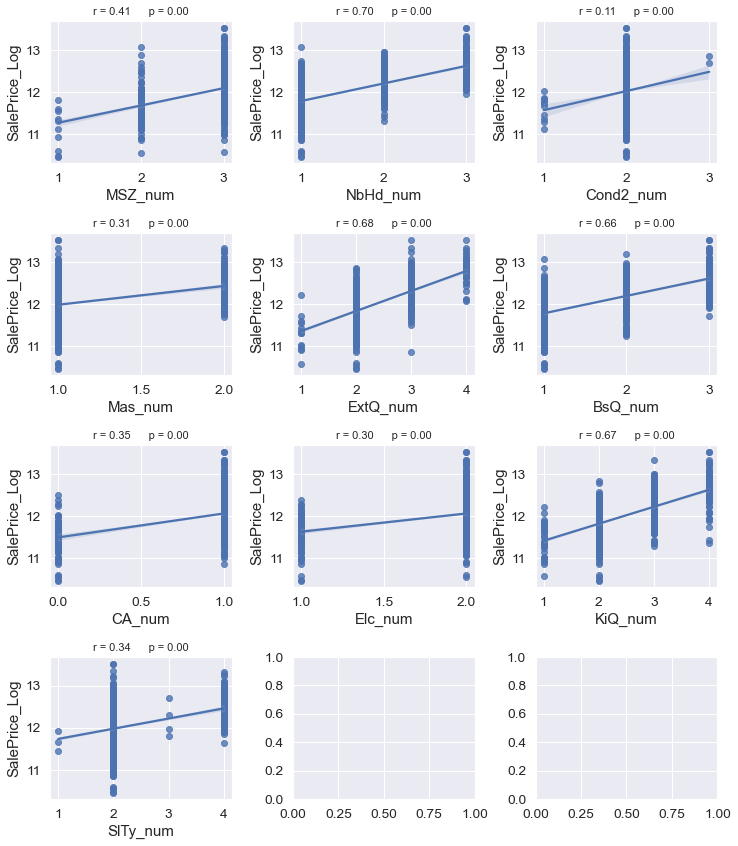

In [163]:
new_col_num = ['MSZ_num', 'NbHd_num', 'Cond2_num', 'Mas_num', 'ExtQ_num', 'BsQ_num', 'CA_num', 'Elc_num', 'KiQ_num', 'SlTy_num']

nr_rows = 4
nr_cols = 3

fig, axs = plt.subplots(nr_rows, nr_cols, figsize=(nr_cols*3.5,nr_rows*3))

for r in range(0,nr_rows):
    for c in range(0,nr_cols):  
        i = r*nr_cols+c
        if i < len(new_col_num):
            sns.regplot(x=df_train[new_col_num[i]],y= df_train[target], ax = axs[r][c])
            stp = stats.pearsonr(df_train[new_col_num[i]], df_train[target])
            str_title = "r = " + "{0:.2f}".format(stp[0]) + "      " "p = " + "{0:.2f}".format(stp[1])
            axs[r][c].set_title(str_title,fontsize=11)
            
plt.tight_layout()    
plt.show()   

There are few columns with quite large correlation to SalePrice (NbHd_num, ExtQ_num, BsQ_num, KiQ_num).  
These will probably be useful for optimal performance of the Regressors in part 3.

**Dropping the converted categorical columns and the new numerical columns with weak correlation**

**columns and correlation before dropping**

In [164]:
catg_cols_to_drop = ['Neighborhood' , 'Condition2', 'MasVnrType', 'ExterQual', 'BsmtQual','CentralAir', 'Electrical', 'KitchenQual', 'SaleType']

corr1 = df_train.corr()
corr_abs_1 = corr1.abs()

nr_all_cols = len(df_train)
ser_corr_1 = corr_abs_1.nlargest(nr_all_cols, target)[target]

print(ser_corr_1)
cols_bel_corr_limit_1 = list(ser_corr_1[ser_corr_1.values <= min_val_corr].index)


for df in [df_train, df_test] :
    df.drop(catg_cols_to_drop, inplace= True, axis = 1)
    df.drop(cols_bel_corr_limit_1, inplace= True, axis = 1)    

SalePrice_Log    1.000000
OverallQual      0.821404
GrLivArea_Log    0.737427
NbHd_num         0.696962
ExtQ_num         0.682225
GarageCars       0.681033
KiQ_num          0.669989
BsQ_num          0.661286
GarageArea       0.656128
TotalBsmtSF      0.647563
1stFlrSF         0.620500
FullBath         0.595899
YearBuilt        0.587043
YearRemodAdd     0.565992
TotRmsAbvGrd     0.537702
GarageYrBlt      0.500842
Fireplaces       0.491998
MasVnrArea       0.433353
MSZ_num          0.409423
LotArea_Log      0.402814
CA_num           0.351598
SlTy_num         0.337469
Mas_num          0.313280
Elc_num          0.304857
Cond2_num        0.107610
Name: SalePrice_Log, dtype: float64


**columns and correlation after dropping**

In [165]:
corr2 = df_train.corr()
corr_abs_2 = corr2.abs()

nr_all_cols = len(df_train)
ser_corr_2 = corr_abs_2.nlargest(nr_all_cols, target)[target]

print(ser_corr_2)

SalePrice_Log    1.000000
OverallQual      0.821404
GrLivArea_Log    0.737427
NbHd_num         0.696962
ExtQ_num         0.682225
GarageCars       0.681033
KiQ_num          0.669989
BsQ_num          0.661286
GarageArea       0.656128
TotalBsmtSF      0.647563
1stFlrSF         0.620500
FullBath         0.595899
YearBuilt        0.587043
YearRemodAdd     0.565992
TotRmsAbvGrd     0.537702
GarageYrBlt      0.500842
Fireplaces       0.491998
MasVnrArea       0.433353
MSZ_num          0.409423
LotArea_Log      0.402814
Name: SalePrice_Log, dtype: float64


**new dataframes**

In [166]:
df_train.head()

,MSZoning,OverallQual,YearBuilt,YearRemodAdd,MasVnrArea,TotalBsmtSF,1stFlrSF,FullBath,TotRmsAbvGrd,Fireplaces,...,GarageCars,GarageArea,SalePrice_Log,GrLivArea_Log,LotArea_Log,MSZ_num,NbHd_num,ExtQ_num,BsQ_num,KiQ_num
0,RL,7,2003,2003,196.0,856,856,2,8,0,...,2,548,12.247694,7.444249,9.041922,3,2,3,2,3
1,RL,6,1976,1976,0.0,1262,1262,2,6,1,...,2,460,12.109011,7.140453,9.169518,3,2,2,2,2
2,RL,7,2001,2002,162.0,920,920,2,6,1,...,2,608,12.317167,7.487734,9.328123,3,2,3,2,3
3,RL,7,1915,1970,0.0,756,961,1,7,1,...,3,642,11.849398,7.448334,9.164296,3,2,2,1,3
4,RL,8,2000,2000,350.0,1145,1145,2,9,1,...,3,836,12.429216,7.695303,9.565214,3,3,3,2,3


In [167]:
df_test.head()

,MSZoning,OverallQual,YearBuilt,YearRemodAdd,MasVnrArea,TotalBsmtSF,1stFlrSF,FullBath,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,GrLivArea_Log,LotArea_Log,MSZ_num,NbHd_num,ExtQ_num,BsQ_num,KiQ_num
0,RH,5,1961,1961,0.0,882.0,896,1,5,0,1961.0,1.0,730.0,6.797940,9.360655,2,1,2,1,2
1,RL,6,1958,1958,108.0,1329.0,1329,1,6,0,1958.0,1.0,312.0,7.192182,9.565704,3,1,2,1,3
2,RL,5,1997,1998,0.0,928.0,928,2,6,1,1997.0,2.0,482.0,7.395722,9.534595,3,2,2,2,2
3,RL,6,1998,1998,20.0,926.0,926,2,7,1,1998.0,2.0,470.0,7.380256,9.208138,3,2,2,1,3
4,RL,8,1992,1992,0.0,1280.0,1280,2,5,0,1992.0,2.0,506.0,7.154615,8.518193,3,3,3,2,3


**List of all features with strong correlation to SalePrice_Log**  
after dropping all coumns with weak correlation

In [168]:
corr = df_train.corr()
corr_abs = corr.abs()

nr_all_cols = len(df_train)
print (corr_abs.nlargest(nr_all_cols, target)[target])

SalePrice_Log    1.000000
OverallQual      0.821404
GrLivArea_Log    0.737427
NbHd_num         0.696962
ExtQ_num         0.682225
GarageCars       0.681033
KiQ_num          0.669989
BsQ_num          0.661286
GarageArea       0.656128
TotalBsmtSF      0.647563
1stFlrSF         0.620500
FullBath         0.595899
YearBuilt        0.587043
YearRemodAdd     0.565992
TotRmsAbvGrd     0.537702
GarageYrBlt      0.500842
Fireplaces       0.491998
MasVnrArea       0.433353
MSZ_num          0.409423
LotArea_Log      0.402814
Name: SalePrice_Log, dtype: float64


### Correlation Matrix 2 : All features with strong correlation to SalePrice

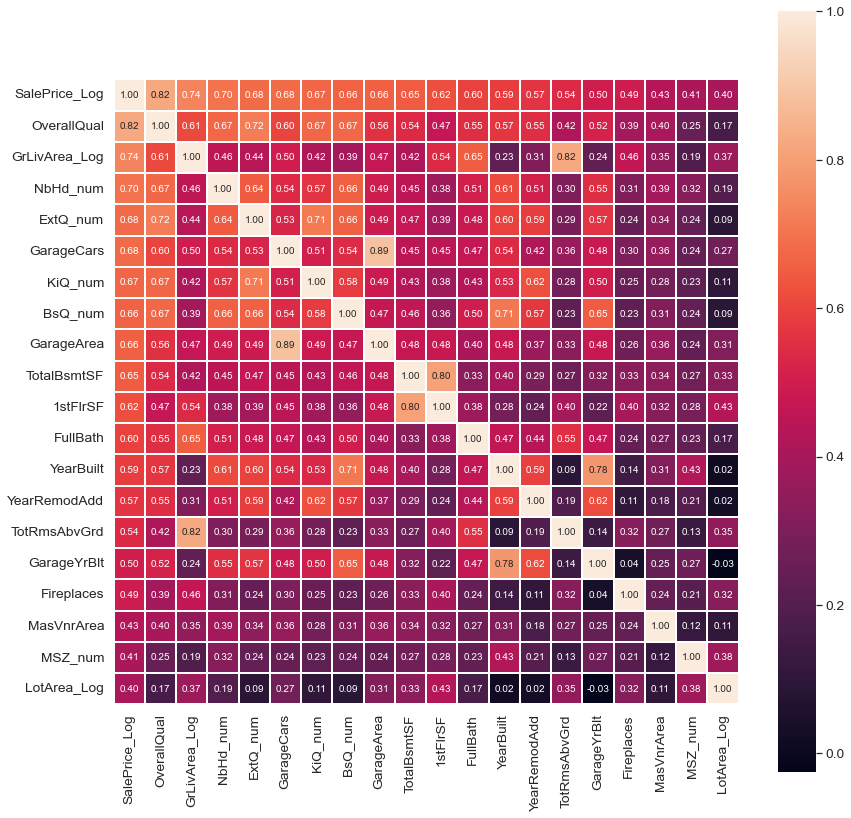

In [169]:
nr_feats=len(df_train.columns)
plot_corr_matrix(df_train, nr_feats, target)

**Check for Multicollinearity**

Strong correlation of these features to other, similar features:

'GrLivArea_Log' and 'TotRmsAbvGrd'

'GarageCars' and 'GarageArea'

'TotalBsmtSF' and '1stFlrSF'

'YearBuilt' and 'GarageYrBlt'

**Of those features we drop the one that has smaller correlation coeffiecient to Target.**

In [170]:
cols = corr_abs.nlargest(nr_all_cols, target)[target].index
cols = list(cols)

if drop_similar == 1 :
    for col in ['GarageArea','1stFlrSF','TotRmsAbvGrd','GarageYrBlt'] :
        if col in cols: 
            cols.remove(col)

In [171]:
cols = list(cols)
print(cols)

['SalePrice_Log', 'OverallQual', 'GrLivArea_Log', 'NbHd_num', 'ExtQ_num', 'GarageCars', 'KiQ_num', 'BsQ_num', 'TotalBsmtSF', 'FullBath', 'YearBuilt', 'YearRemodAdd', 'Fireplaces', 'MasVnrArea', 'MSZ_num', 'LotArea_Log']


**List of features used for the Regressors in Part 3**

In [172]:
feats = cols.copy()
feats.remove('SalePrice_Log')

print(feats)

['OverallQual', 'GrLivArea_Log', 'NbHd_num', 'ExtQ_num', 'GarageCars', 'KiQ_num', 'BsQ_num', 'TotalBsmtSF', 'FullBath', 'YearBuilt', 'YearRemodAdd', 'Fireplaces', 'MasVnrArea', 'MSZ_num', 'LotArea_Log']


In [173]:
df_train_ml = df_train[feats].copy()
df_test_ml  = df_test[feats].copy()

y = df_train[target]

**Combine train and test data**  
for one hot encoding (use pandas get dummies) of all categorical features  
uncommenting the following cell increases the number of features  
up to now, all models in Part 3 are optimized for not applying one hot encoder  
when applied, GridSearchCV needs to be rerun

In [174]:

all_data = pd.concat((df_train[feats], df_test[feats]))

li_get_dummies = ['OverallQual', 'NbHd_num', 'GarageCars','ExtQ_num', 'KiQ_num',
                  'BsQ_num', 'FullBath', 'Fireplaces', 'MSZ_num']
all_data = pd.get_dummies(all_data, columns=li_get_dummies, drop_first=True)

df_train_ml = all_data[:df_train.shape[0]]
df_test_ml  = all_data[df_train.shape[0]:]


### StandardScaler

In [175]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
df_train_ml_sc = sc.fit_transform(df_train_ml)
df_test_ml_sc = sc.transform(df_test_ml)

In [176]:
df_train_ml_sc = pd.DataFrame(df_train_ml_sc)
df_train_ml_sc.head()

,0,1,2,3,4,5,6,7,8,9,...,31,32,33,34,35,36,37,38,39,40
0,0.539624,-0.473766,1.052959,0.880362,0.521228,-0.129585,-0.045408,-0.117933,-0.294004,-0.611699,...,-0.896914,0.949164,-0.149801,0.0,-0.895670,-0.292625,-0.05245,0.0,-0.437237,0.448317
1,-0.380198,0.504925,0.158428,-0.428115,-0.574433,0.118848,-0.045408,-0.117933,-0.294004,-0.611699,...,-0.896914,0.949164,-0.149801,0.0,1.116482,-0.292625,-0.05245,0.0,-0.437237,0.448317
2,0.671287,-0.319490,0.986698,0.831900,0.331164,0.427653,-0.045408,-0.117933,-0.294004,-0.611699,...,-0.896914,0.949164,-0.149801,0.0,1.116482,-0.292625,-0.05245,0.0,-0.437237,0.448317
3,0.551993,-0.714823,-1.862551,-0.718888,-0.574433,0.108680,-0.045408,-0.117933,-0.294004,-0.611699,...,1.114934,-1.053559,-0.149801,0.0,1.116482,-0.292625,-0.05245,0.0,-0.437237,0.448317
4,1.299759,0.222888,0.953567,0.734975,1.382104,0.889271,-0.045408,-0.117933,-0.294004,-0.611699,...,-0.896914,0.949164,-0.149801,0.0,1.116482,-0.292625,-0.05245,0.0,-0.437237,0.448317


**Creating Datasets for ML algorithms**

In [177]:
X = df_train_ml.copy()
y = df_train[target]
X_test = df_test_ml.copy()

X_sc = df_train_ml_sc.copy()
y_sc = df_train[target]
X_test_sc = df_test_ml_sc.copy()

X.info()
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1458 entries, 0 to 1459
Data columns (total 41 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   GrLivArea_Log                  1458 non-null   float64
 1   TotalBsmtSF                    1458 non-null   float64
 2   YearBuilt                      1458 non-null   int64  
 3   YearRemodAdd                   1458 non-null   int64  
 4   MasVnrArea                     1458 non-null   float64
 5   LotArea_Log                    1458 non-null   float64
 6   OverallQual_2                  1458 non-null   uint8  
 7   OverallQual_3                  1458 non-null   uint8  
 8   OverallQual_4                  1458 non-null   uint8  
 9   OverallQual_5                  1458 non-null   uint8  
 10  OverallQual_6                  1458 non-null   uint8  
 11  OverallQual_7                  1458 non-null   uint8  
 12  OverallQual_8                  1458 non-null   u

In [178]:
X.head()

,GrLivArea_Log,TotalBsmtSF,YearBuilt,YearRemodAdd,MasVnrArea,LotArea_Log,OverallQual_2,OverallQual_3,OverallQual_4,OverallQual_5,...,FullBath_1,FullBath_2,FullBath_3,FullBath_4,Fireplaces_1,Fireplaces_2,Fireplaces_3,Fireplaces_4,MSZ_num_2,MSZ_num_3
0,7.444249,856.0,2003,2003,196.0,9.041922,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
1,7.140453,1262.0,1976,1976,0.0,9.169518,0,0,0,0,...,0,1,0,0,1,0,0,0,0,1
2,7.487734,920.0,2001,2002,162.0,9.328123,0,0,0,0,...,0,1,0,0,1,0,0,0,0,1
3,7.448334,756.0,1915,1970,0.0,9.164296,0,0,0,0,...,1,0,0,0,1,0,0,0,0,1
4,7.695303,1145.0,2000,2000,350.0,9.565214,0,0,0,0,...,0,1,0,0,1,0,0,0,0,1


In [179]:
X_sc.head()

,0,1,2,3,4,5,6,7,8,9,...,31,32,33,34,35,36,37,38,39,40
0,0.539624,-0.473766,1.052959,0.880362,0.521228,-0.129585,-0.045408,-0.117933,-0.294004,-0.611699,...,-0.896914,0.949164,-0.149801,0.0,-0.895670,-0.292625,-0.05245,0.0,-0.437237,0.448317
1,-0.380198,0.504925,0.158428,-0.428115,-0.574433,0.118848,-0.045408,-0.117933,-0.294004,-0.611699,...,-0.896914,0.949164,-0.149801,0.0,1.116482,-0.292625,-0.05245,0.0,-0.437237,0.448317
2,0.671287,-0.319490,0.986698,0.831900,0.331164,0.427653,-0.045408,-0.117933,-0.294004,-0.611699,...,-0.896914,0.949164,-0.149801,0.0,1.116482,-0.292625,-0.05245,0.0,-0.437237,0.448317
3,0.551993,-0.714823,-1.862551,-0.718888,-0.574433,0.108680,-0.045408,-0.117933,-0.294004,-0.611699,...,1.114934,-1.053559,-0.149801,0.0,1.116482,-0.292625,-0.05245,0.0,-0.437237,0.448317
4,1.299759,0.222888,0.953567,0.734975,1.382104,0.889271,-0.045408,-0.117933,-0.294004,-0.611699,...,-0.896914,0.949164,-0.149801,0.0,1.116482,-0.292625,-0.05245,0.0,-0.437237,0.448317


In [180]:
X_test.head()

,GrLivArea_Log,TotalBsmtSF,YearBuilt,YearRemodAdd,MasVnrArea,LotArea_Log,OverallQual_2,OverallQual_3,OverallQual_4,OverallQual_5,...,FullBath_1,FullBath_2,FullBath_3,FullBath_4,Fireplaces_1,Fireplaces_2,Fireplaces_3,Fireplaces_4,MSZ_num_2,MSZ_num_3
0,6.797940,882.0,1961,1961,0.0,9.360655,0,0,0,1,...,1,0,0,0,0,0,0,0,1,0
1,7.192182,1329.0,1958,1958,108.0,9.565704,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
2,7.395722,928.0,1997,1998,0.0,9.534595,0,0,0,1,...,0,1,0,0,1,0,0,0,0,1
3,7.380256,926.0,1998,1998,20.0,9.208138,0,0,0,0,...,0,1,0,0,1,0,0,0,0,1
4,7.154615,1280.0,1992,1992,0.0,8.518193,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1


# Part 3: Scikit-learn basic regression models and comparison of results

**Test simple sklearn models and compare by metrics**

**We test the following Regressors from scikit-learn:**  
LinearRegression  
DecisionTreeRegressor  
RandomForestRegressor  

**Model tuning and selection with GridSearchCV**

In [181]:
from sklearn.model_selection import GridSearchCV
score_calc = 'neg_mean_squared_error'

### Linear Regression

In [182]:
from sklearn.linear_model import LinearRegression

linreg = LinearRegression()
parameters = {'fit_intercept':[True,False], 'copy_X':[True, False]}
grid_linear = GridSearchCV(linreg, parameters, cv=nr_cv, verbose=1 , scoring = score_calc)
grid_linear.fit(X, y)

sc_linear = get_best_score(grid_linear)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
0.1342024199022768
{'copy_X': True, 'fit_intercept': True}
LinearRegression()


In [183]:
linreg_sc = LinearRegression()
parameters = {'fit_intercept':[True,False], 'copy_X':[True, False]}
grid_linear_sc = GridSearchCV(linreg_sc, parameters, cv=nr_cv, verbose=1 , scoring = score_calc)
grid_linear_sc.fit(X_sc, y)

sc_linear_sc = get_best_score(grid_linear_sc)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
0.13434551963432517
{'copy_X': True, 'fit_intercept': True}
LinearRegression()


In [184]:
linregr_all = LinearRegression()
#linregr_all.fit(X_train_all, y_train_all)
linregr_all.fit(X, y)
pred_linreg_all = linregr_all.predict(X_test)
pred_linreg_all[pred_linreg_all < 0] = pred_linreg_all.mean()

In [185]:
out_linreg = pd.DataFrame()
out_linreg['Id'] = id_test
out_linreg['SalePrice'] = pred_linreg_all
if use_logvals == 1:
    out_linreg['SalePrice'] = np.exp(out_linreg['SalePrice']) 
#sub_linreg.to_csv('linreg.csv',index=False)
out_linreg.head()

,Id,SalePrice
0,1461,107932.947626
1,1462,155182.547015
2,1463,181165.923667
3,1464,188163.784698
4,1465,198931.757362


### DecisionTreeRegressor

In [186]:
from sklearn.tree import DecisionTreeRegressor

param_grid = { 'max_depth' : [7,8,9,10] , 'max_features' : [11,12,13,14] ,
               'max_leaf_nodes' : [None, 12,15,18,20] ,'min_samples_split' : [20,25,30],
                 'random_state': [5] }
            
grid_dtree = GridSearchCV(DecisionTreeRegressor(),param_grid, cv=nr_cv, refit=True, verbose=1, scoring = score_calc)
grid_dtree.fit(X, y)

sc_dtree = get_best_score(grid_dtree)

pred_dtree = grid_dtree.predict(X_test)

Fitting 5 folds for each of 240 candidates, totalling 1200 fits
0.20490190438121827
{'max_depth': 8, 'max_features': 12, 'max_leaf_nodes': None, 'min_samples_split': 30, 'random_state': 5}
DecisionTreeRegressor(max_depth=8, max_features=12, min_samples_split=30,
                      random_state=5)


In [187]:
dtree_pred = grid_dtree.predict(X_test)
out_dtree = pd.DataFrame()
out_dtree['Id'] = id_test
out_dtree['SalePrice'] = dtree_pred
if use_logvals == 1:
    out_dtree['SalePrice'] = np.exp(out_dtree['SalePrice']) 
#sub_dtree.to_csv('dtreeregr.csv',index=False)

out_dtree.head()

,Id,SalePrice
0,1461,116240.684958
1,1462,157924.774982
2,1463,178708.790498
3,1464,203297.727434
4,1465,213601.027350


### RandomForestRegressor

In [188]:
from sklearn.ensemble import RandomForestRegressor

param_grid = {'min_samples_split' : [3,4,6,10], 'n_estimators' : [70,100], 'random_state': [5] }
grid_rf = GridSearchCV(RandomForestRegressor(), param_grid, cv=nr_cv, refit=True, verbose=1, scoring = score_calc)
grid_rf.fit(X, y)

sc_rf = get_best_score(grid_rf)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
0.15396949280837008
{'min_samples_split': 3, 'n_estimators': 100, 'random_state': 5}
RandomForestRegressor(min_samples_split=3, random_state=5)


In [189]:
pred_rf = grid_rf.predict(X_test)

out_rf = pd.DataFrame()
out_rf['Id'] = id_test
out_rf['SalePrice'] = pred_rf 

if use_logvals == 1:
    out_rf['SalePrice'] = np.exp(out_rf['SalePrice']) 

#out_rf.to_csv('rf.csv',index=False)

In [190]:
out_rf.head(10)

,Id,SalePrice
0,1461,121025.523706
1,1462,124931.656471
2,1463,174599.475216
3,1464,187115.156032
4,1465,197820.845019
5,1466,177495.512821
6,1467,166220.660930
7,1468,175389.903043
8,1469,179285.965278
9,1470,117796.127472


### Comparison plot: RMSE of all models

In [191]:
list_scores = [sc_linear,sc_dtree, sc_rf]
list_regressors = ['Linear','DTr','RF']

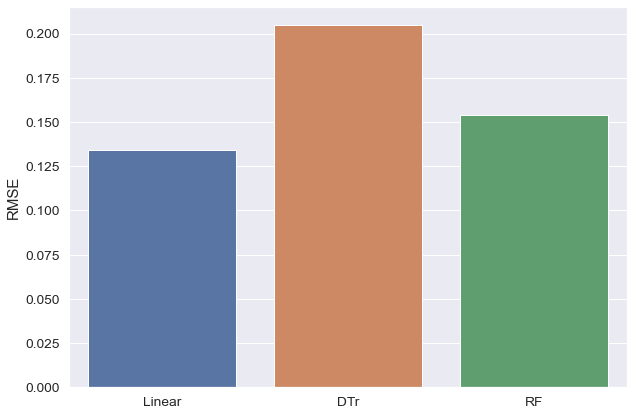

In [192]:
fig, ax = plt.subplots()
fig.set_size_inches(10,7)
sns.barplot(x=list_regressors, y=list_scores, ax=ax)
plt.ylabel('RMSE')
plt.show()

The performance of all applied Regressors is very similar, except for Decision Tree which has larger RMSE than the other models.

### Correlation of model results

In [193]:
predictions = {'Linear': pred_linreg_all, 'DTr': pred_dtree, 'RF': pred_rf}
df_predictions = pd.DataFrame(data=predictions) 
df_predictions.corr()

,Linear,DTr,RF
Linear,1.000000,0.901858,0.969081
DTr,0.901858,1.000000,0.907091
RF,0.969081,0.907091,1.000000


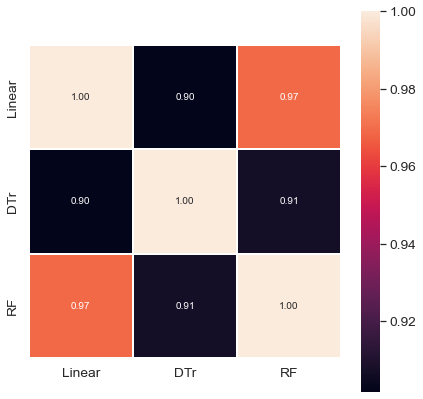

In [194]:
plt.figure(figsize=(7, 7))
sns.set(font_scale=1.25)
sns.heatmap(df_predictions.corr(), linewidths=1.5, annot=True, square=True, 
                fmt='.2f', annot_kws={'size': 10}, 
                yticklabels=df_predictions.columns , xticklabels=df_predictions.columns
            )
plt.show()

**OUTPUT CSV:**

In [195]:
out_rf.head()

,Id,SalePrice
0,1461,121025.523706
1,1462,124931.656471
2,1463,174599.475216
3,1464,187115.156032
4,1465,197820.845019
